# 프로젝트 : CutMix 또는 Mixup 비교실험하기

## Step 1. Augmentation을 적용한 데이터셋 만들기

In [1]:
# 필요한 모듈 Import
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 데이터 불러오기
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


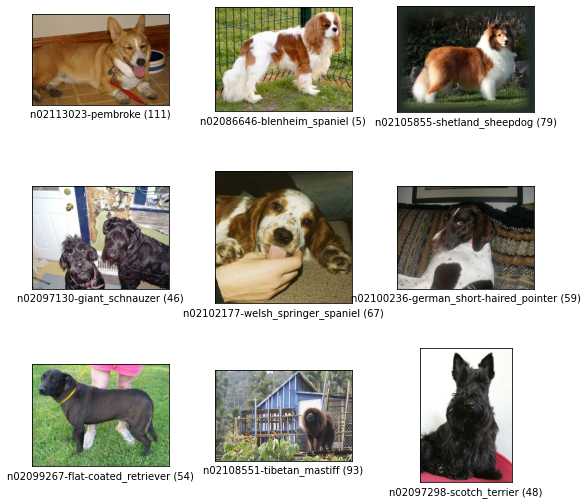

In [4]:
fig = tfds.show_examples(ds_info, ds_train)

In [5]:
# 필요한 함수 만들기
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image,label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [6]:
# cumix와 관련되어서 필요한 함수 만들기
def get_clip_box(image_a, image_b, img_size=224):
    # get center of box
    x = tf.cast( tf.random.uniform([],0, img_size),tf.int32)
    y = tf.cast( tf.random.uniform([],0, img_size),tf.int32)

    # get width of box
    _prob = tf.random.uniform([],0,1)
    width = tf.cast(img_size * tf.math.sqrt(1-_prob),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-width//2)
    yb = tf.math.minimum(img_size, y+width//2)
    xb = tf.math.minimum(img_size, x+width//2)
    
    return xa, ya, xb, yb

def mix_2_images(image_a, image_b, xa, ya, xb, yb, img_size=224):
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:img_size,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:img_size,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_label(label_a, label_b, xa, ya, xb, yb, img_size=224, num_classes=120):
    mixed_area = (xb-xa)*(yb-ya)
    total_area = img_size*img_size
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [7]:
# Mixup과 관련되어 필요한 함수 만들기
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [8]:
def onehot(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    imgs = []
    labels = []
    
    for i in range(batch_size):
        imgs.append(image[i])
        labels.append(tf.one_hot(label[i], num_classes))
    
    imgs = tf.reshape(tf.stack(imgs), (batch_size, img_size, img_size, 3))
    return imgs, labels

## Step 2. 모델 만들기

In [9]:
num_classes = ds_info.features['label'].num_classes

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [10]:
# augmentation 적용
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [11]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top = False,
        weights = 'imagenet',
        input_shape = (224, 224, 3),
        pooling = 'avg'
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [13]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_aug = True, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_aug = True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

## Step 3. 모델 훈련하기

In [14]:
tf.random.set_seed(2020)

In [16]:
import os

checkpoint_base_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/checkpoint/'

In [18]:
resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

res_checkpoint_path = checkpoint_base_path + 'res50.ckpt'
res_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath = res_checkpoint_path,
                                                  save_weights_only = True, verbose = 1)

history_resnet50 = resnet50.fit(
    ds_train_no_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
    callbacks = [res_callbacks]
)

Epoch 1/10
  2/750 [..............................] - ETA: 1:32 - loss: 2.9319 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0565s vs `on_train_batch_end` time: 0.0994s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 1.7904 - accuracy: 0.5355WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0073s vs `on_test_batch_end` time: 0.0290s). Check your callbacks.



Epoch 00001: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/res50.ckpt
750/750 [==============================] - 113s 151ms/step - loss: 1.7904 - accuracy: 0.5355 - val_loss: 2.3881 - val_accuracy: 0.3710
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.8107
Epoch 00002: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/res50.ckpt
750/750 [==============================] - 113s 151ms/step - loss: 0.6805 - accuracy: 0.8107 - val_loss: 1.0895 - val_accuracy: 0.6854
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.2489 - accuracy: 0.9457
Epoch 00003: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/res50.ckpt
750/750 [==============================] - 114s 152ms/step - loss: 0.2489 - accuracy: 0.9457 - val_loss: 1.1869 - val_accuracy: 0.6692
Epoch 4/10
750/750 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0

In [20]:
aug_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

aug_resnet50_checkpoint_path = checkpoint_base_path + 'aug_res50.ckpt'
aug_resnet_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath = aug_resnet50_checkpoint_path,
                                                  save_weights_only = True,
                                                  verbose=1)


history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
    callbacks = [aug_resnet_callbacks]
)

Epoch 1/10
  2/750 [..............................] - ETA: 1:26 - loss: 5.1578 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0492s vs `on_train_batch_end` time: 0.0895s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 2.2381 - accuracy: 0.4405WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0069s vs `on_test_batch_end` time: 0.0292s). Check your callbacks.



Epoch 00001: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/aug_res50.ckpt
750/750 [==============================] - 114s 152ms/step - loss: 2.2381 - accuracy: 0.4405 - val_loss: 2.9131 - val_accuracy: 0.2795
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.7212
Epoch 00002: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/aug_res50.ckpt
750/750 [==============================] - 113s 151ms/step - loss: 0.9672 - accuracy: 0.7212 - val_loss: 1.1353 - val_accuracy: 0.6706
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 0.4924 - accuracy: 0.8662
Epoch 00003: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/aug_res50.ckpt
750/750 [==============================] - 114s 151ms/step - loss: 0.4924 - accuracy: 0.8662 - val_loss: 1.1249 - val_accuracy: 0.6788
Epoch 4/10
750/750 [==============================] - ETA: 0s - loss: 0.3126 -

In [21]:
cutmix_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

cutmix_checkpoint_path = checkpoint_base_path + 'cutmmix.ckpt'
cutmix_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath = cutmix_checkpoint_path,
                                                     save_weights_only = True, verbose = 1)


history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
    callbacks = [cutmix_callbacks]
)

Epoch 1/10
  2/750 [..............................] - ETA: 1:20 - loss: 5.0205 - accuracy: 0.0000e+00WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0445s vs `on_train_batch_end` time: 0.0802s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.8589 - accuracy: 0.2050WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0078s vs `on_test_batch_end` time: 0.0288s). Check your callbacks.



Epoch 00001: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/cutmmix.ckpt
750/750 [==============================] - 115s 153ms/step - loss: 3.8589 - accuracy: 0.2050 - val_loss: 3.0454 - val_accuracy: 0.2600
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 2.9854 - accuracy: 0.4221
Epoch 00002: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/cutmmix.ckpt
750/750 [==============================] - 115s 153ms/step - loss: 2.9854 - accuracy: 0.4221 - val_loss: 1.6617 - val_accuracy: 0.5387
Epoch 3/10
750/750 [==============================] - ETA: 0s - loss: 2.7149 - accuracy: 0.4974
Epoch 00003: saving model to /home/aiffel0039/Documents/GitHub/aiffel/Week11/data/checkpoint/cutmmix.ckpt
750/750 [==============================] - 115s 153ms/step - loss: 2.7149 - accuracy: 0.4974 - val_loss: 1.2721 - val_accuracy: 0.6411
Epoch 4/10
750/750 [==============================] - ETA: 0s - loss: 2.5474 - accur

In [22]:
mixup_resnet50.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=0.01),
    metrics = ['accuracy']
)

mixup_checkpoint_path = checkpoint_base_path + 'mixup.ckpt'
mixup_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath = mixup_checkpoint_path,
                                                    save_weights_only = True, verbose = 1)

history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch = int(ds_info.splits['train'].num_examples/16),
    validation_steps = int(ds_info.splits['test'].num_examples/16),
    epochs = 10,
    validation_data = ds_test,
    verbose = 1,
    use_multiprocessing = True,
    callbacks = [mixup_callbacks]
)

Epoch 1/10
  2/750 [..............................] - ETA: 1:26 - loss: 4.8461 - accuracy: 0.0312WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0490s vs `on_train_batch_end` time: 0.0907s). Check your callbacks.


750/750 [==============================] - ETA: 0s - loss: 3.7285 - accuracy: 0.2361WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0068s vs `on_test_batch_end` time: 0.0287s). Check your callbacks.


750/750 [==============================] - 113s 151ms/step - loss: 3.7285 - accuracy: 0.2361 - val_loss: 4.1089 - val_accuracy: 0.1088
Epoch 2/10
750/750 [==============================] - 113s 150ms/step - loss: 2.9212 - accuracy: 0.4557 - val_loss: 1.8008 - val_accuracy: 0.5101
Epoch 3/10
750/750 [==============================] - 113s 150ms/step - loss: 2.6614 - accuracy: 0.5493 - val_loss: 1.5204 - val_accuracy: 0.5958
Epoch 4/10
750/750 [==============================] - 113s 150ms/step - loss: 2.5095 - accuracy: 0.6047 - val_loss: 1.2597 - val_accuracy: 0.6518
Epoch 5/10
750/750 [==============================] - 113s 150ms/step - loss: 2.3773 - accuracy: 0.6578 - val_loss: 1.3049 - val_accuracy: 0.6448
Epoch 6/10
750/750 [==============================] - 113s 150ms/step - loss: 2.2864 - accuracy: 0.6916 - val_loss: 1.2033 - val_accuracy: 0.6677
Epoch 7/10
750/750 [==============================] - 113s 150ms/step - loss: 2.2288 - accuracy: 0.7109 - val_loss: 1.2879 - val_accura

## Step 4. 훈련 과정 시각화하기

### Augmentation에 의한 모델 성능 비교

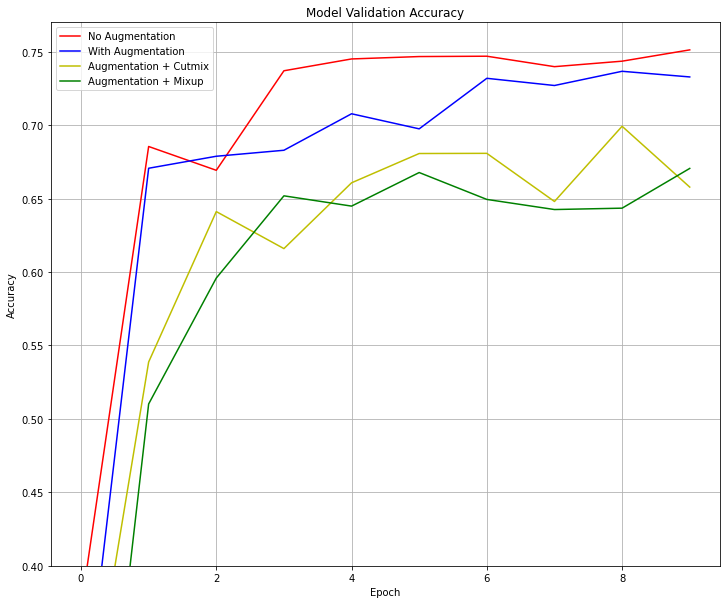

In [28]:
plt.figure(figsize = (12, 10))

plt.plot(history_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50.history['val_accuracy'], 'y')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'g')

plt.title("Model Validation Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['No Augmentation', 'With Augmentation', 'Augmentation + Cutmix', 'Augmentation + Mixup'], loc = 'upper left')
plt.grid(True)
plt.ylim(0.4, 0.77)

plt.show()

재미있는 결과가 나왔습니다.

Augmentation을 하지 않은 모델이 제일 accuracy가 높게 나왔네요 ^^.. 그 다음이 단순하게 augmentation을 한 것이고 cutmat가 mixup보다는 약간 더 좋은 결과를 보이고 있습니다.
